In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File with effective mass output.
base = 'test_pion_mass_output/'
file = base + 'su3_w_b5.70_N20_skip10_therm100_8_8_8_8_output.txt'

In [3]:
f = open(file, 'r')

# discard the first two lines
f.readline()
f.readline()
n_t = []
C = []
for line in f:
    left, right = line.split(' | ')
    real, imag = right.split(' + i(')
    n_t.append(int(left))
    C.append(np.complex(float(real), float(imag[:-2])))
f.close()

In [4]:
m = []
for i in range(len(n_t) - 1):
    m.append(np.log(np.abs(C[i]) / np.abs(C[i + 1])))

Text(0, 0.5, '$log(C(n_t))$')

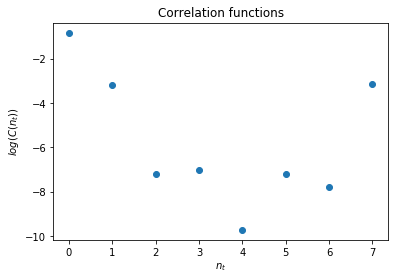

In [5]:
plt.figure()
plt.scatter(n_t, np.log(np.abs(C)))
plt.title('Correlation functions')
plt.xlabel('$n_t$')
plt.ylabel('$log(C(n_t))$')

Text(0, 0.5, '$m_{eff}$')

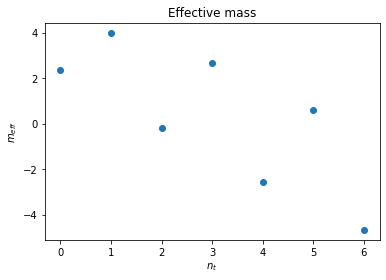

In [6]:
plt.figure()
plt.scatter(n_t[:-1], m)
plt.title('Effective mass')
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')